In [1]:
import numpy as np
import scipy.optimize as opt
import sys
import astropy.io.fits as pyfits
import math
import matplotlib.pylab as plt
import pickle
import time
from scipy.interpolate import Rbf
import katcali.io as kio

In [2]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])


10.0 0.8 1.5
14.0 1.5 1.5


In [3]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')


start @ Thu Dec 26 15:51:11 2024#


In [4]:
def gauss_model(xi, yi, center_x, center_y, sigma):
    r2=(xi-center_x)**2.0+(yi-center_y)**2.0
    result= 1*np.exp(-r2/(2*sigma**2.0))
    return result

def func_obj(param, *args):
    sigma = param[0]
    center_x=param[1]
    center_y=param[2]
    xi=args[0]
    yi=args[1]
    data=args[2]
    
    model_value=gauss_model(xi, yi, center_x, center_y, sigma)
    result= np.sum((model_value-data)**2)
    #print(sigma, result)
    return result

In [5]:
d=np.load('MeerKAT_U_band_primary_beam.npz')


In [6]:
d.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f22dcc43fd0>)

In [7]:
print (d['pols'])

[b'HH' b'HV' b'VH' b'VV']


In [8]:
print (d['antnames'])

[b'm000' b'm001' b'm002' b'm003' b'm004' b'm005' b'm006' b'm007' b'm008'
 b'm009' b'm010' b'm011' b'm012' b'm013' b'm014' b'm015' b'm016' b'm017'
 b'm018' b'm019' b'm020' b'm021' b'm022' b'm023' b'm024' b'm025' b'm026'
 b'm027' b'm028' b'm029' b'm030' b'm031' b'm032' b'm033' b'm034' b'm035'
 b'm036' b'm037' b'm038' b'm039' b'm040' b'm041' b'm042' b'm043' b'm044'
 b'm045' b'm046' b'm047' b'm048' b'm049' b'm050' b'm051' b'm052' b'm053'
 b'm054' b'm055' b'm056' b'm057' b'm058' b'm059' b'm060' b'm061' b'm062'
 b'm063' b'array_average']


In [9]:
freqs_MHz=(d['freq_MHz'])
print (len(freqs_MHz))

1024


In [10]:
margin_deg=d['margin_deg']
print (np.shape(margin_deg))
print (margin_deg)

(128,)
[-6.      -5.90625 -5.8125  -5.71875 -5.625   -5.53125 -5.4375  -5.34375
 -5.25    -5.15625 -5.0625  -4.96875 -4.875   -4.78125 -4.6875  -4.59375
 -4.5     -4.40625 -4.3125  -4.21875 -4.125   -4.03125 -3.9375  -3.84375
 -3.75    -3.65625 -3.5625  -3.46875 -3.375   -3.28125 -3.1875  -3.09375
 -3.      -2.90625 -2.8125  -2.71875 -2.625   -2.53125 -2.4375  -2.34375
 -2.25    -2.15625 -2.0625  -1.96875 -1.875   -1.78125 -1.6875  -1.59375
 -1.5     -1.40625 -1.3125  -1.21875 -1.125   -1.03125 -0.9375  -0.84375
 -0.75    -0.65625 -0.5625  -0.46875 -0.375   -0.28125 -0.1875  -0.09375
  0.       0.09375  0.1875   0.28125  0.375    0.46875  0.5625   0.65625
  0.75     0.84375  0.9375   1.03125  1.125    1.21875  1.3125   1.40625
  1.5      1.59375  1.6875   1.78125  1.875    1.96875  2.0625   2.15625
  2.25     2.34375  2.4375   2.53125  2.625    2.71875  2.8125   2.90625
  3.       3.09375  3.1875   3.28125  3.375    3.46875  3.5625   3.65625
  3.75     3.84375  3.9375   4.03125  4.125 

# margin_deg is shifted by half a pixel, don't use it!

In [11]:
12/128

0.09375

In [12]:
(margin_deg[-1]-margin_deg[0])/127


0.09375

In [13]:
print (np.shape(d['beam']))

(4, 65, 1024, 128, 128)


In [14]:
beam_ave=d['beam'][:,-1,:,:,:] #use the array_average

In [15]:
print (np.shape(beam_ave))

(4, 1024, 128, 128)


In [16]:
Npix=np.shape(beam_ave)[-1]
print (Npix)

128


In [17]:
grid_i=902 #local channel index
freq_local=freqs_MHz[grid_i]
print (freq_local)

1023.1875


In [18]:
print (beam_ave[0,grid_i,:,:])

[[-3.6269455e-04+1.23580554e-04j -5.1596650e-04+2.30467544e-04j
  -6.3988601e-04+3.02684988e-04j ... -3.7223977e-04+2.18958055e-04j
  -2.9715878e-04+1.82079893e-04j -2.0512723e-04+1.20909062e-04j]
 [-4.0696288e-04+9.58129749e-05j -5.3593732e-04+1.98704452e-04j
  -6.3036103e-04+2.65756127e-04j ... -1.9956223e-04+1.26181738e-04j
  -1.6494395e-04+1.09660214e-04j -1.1454763e-04+6.83116523e-05j]
 [-4.1735265e-04+7.58599999e-05j -5.0549867e-04+1.69602135e-04j
  -5.5546936e-04+2.27793935e-04j ...  4.4666591e-05+1.74298202e-05j
   2.6465106e-05+2.34719755e-05j  2.1468642e-05+5.35250365e-06j]
 ...
 [-3.9875926e-05-2.69786571e-04j  6.0115155e-05-2.93908495e-04j
   1.6283608e-04-3.14171455e-04j ...  2.5067443e-04-1.67144695e-04j
   1.5707733e-04-1.85101540e-04j  6.7334156e-05-2.07040153e-04j]
 [-1.7590882e-04-1.81124604e-04j -6.9305665e-05-2.34074061e-04j
   4.3054442e-05-2.86613125e-04j ...  1.5832466e-04-3.70153663e-04j
   6.8645182e-05-3.64120031e-04j -1.5630378e-05-3.58979334e-04j]
 [-2.91639

In [19]:
print (d['pols'])

[b'HH' b'HV' b'VH' b'VV']


In [20]:
img_HH=abs(beam_ave[0,grid_i,:,:])**2 #squared!!!
img_HV=abs(beam_ave[1,grid_i,:,:])**2
img_VH=abs(beam_ave[2,grid_i,:,:])**2
img_VV=abs(beam_ave[3,grid_i,:,:])**2
print (img_HH.max(),img_VV.max())
img_HH=img_HH/img_HH.max()
img_VV=img_VV/img_VV.max()
print (img_HH.max(),img_VV.max())

0.99984074 1.0000031
1.0 1.0


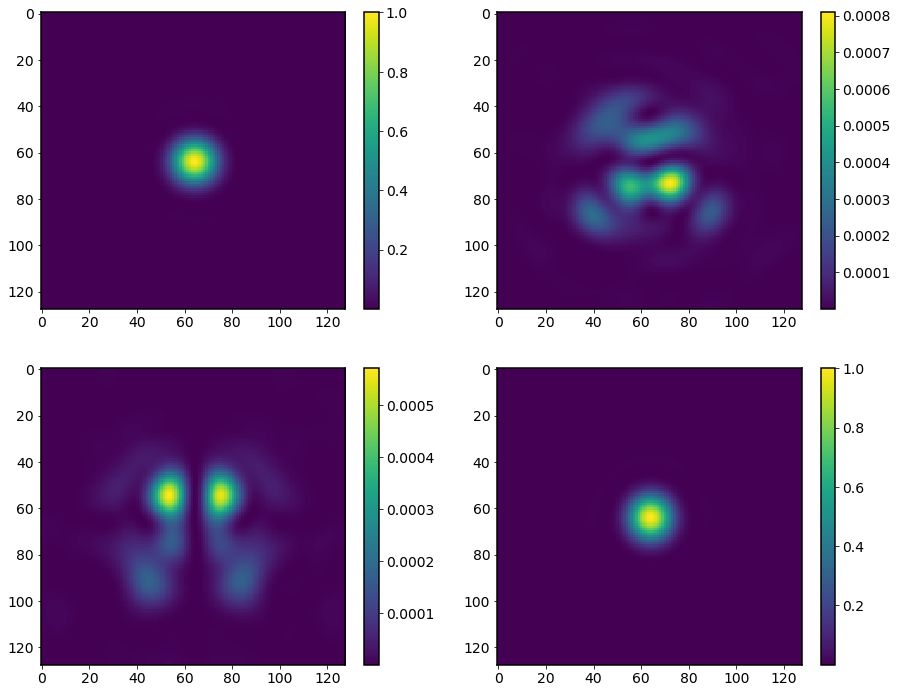

In [21]:
plt.figure(figsize = (15,12))
plt.subplot(221)
plt.imshow(img_HH,aspect='auto')
plt.colorbar()
plt.subplot(222)
plt.imshow(img_HV,aspect='auto')
plt.colorbar()
plt.subplot(223)
plt.imshow(img_VH,aspect='auto')
plt.colorbar()
plt.subplot(224)
plt.imshow(img_VV,aspect='auto')
plt.colorbar()
plt.show()

In [22]:
print (margin_deg[0],margin_deg[-1])

-6.0 5.90625


/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


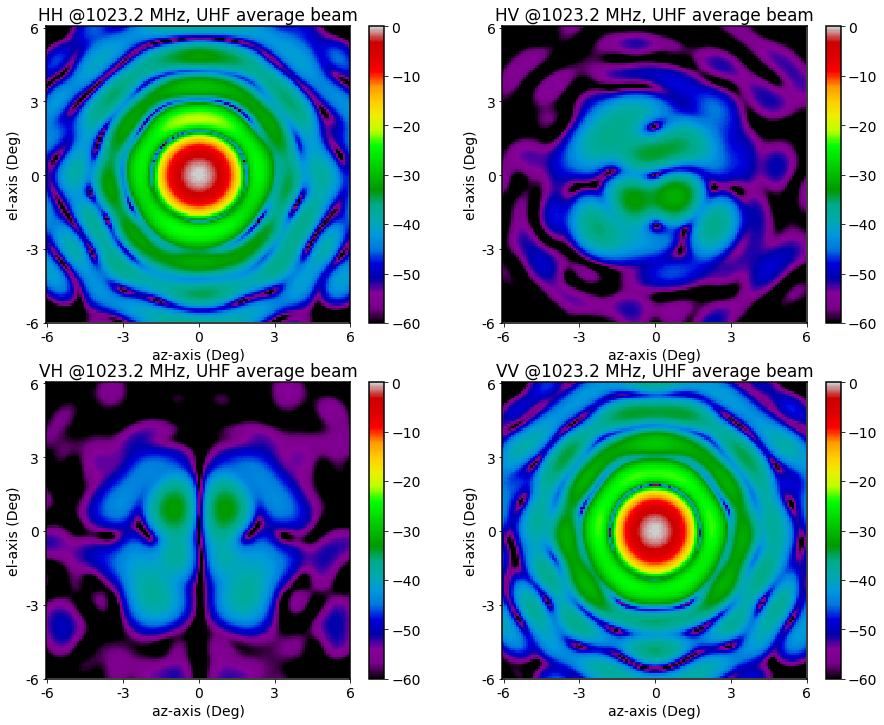

In [23]:
plt.figure(figsize = (15,12))
plt.subplot(221)
plt.imshow(10*np.log10(img_HH),cmap='spectral',aspect='auto')
plt.title('HH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks([0,32,64,96,128],['-6','-3','0','3','6'])
plt.yticks([0,32,64,96,128],['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.subplot(222)
plt.imshow(10*np.log10(img_HV),cmap='spectral',aspect='auto')
plt.title('HV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks([0,32,64,96,128],['-6','-3','0','3','6'])
plt.yticks([0,32,64,96,128],['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.subplot(223)
plt.imshow(10*np.log10(img_VH),cmap='spectral',aspect='auto')
plt.title('VH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks([0,32,64,96,128],['-6','-3','0','3','6'])
plt.yticks([0,32,64,96,128],['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.subplot(224)
plt.imshow(10*np.log10(img_VV),cmap='spectral',aspect='auto')
plt.title('VV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.clim(-60,0)
plt.colorbar()
plt.xticks([0,32,64,96,128],['-6','-3','0','3','6'])
plt.yticks([0,32,64,96,128],['6','3','0','-3','-6'])
plt.xlabel('az-axis (Deg)')
plt.ylabel('el-axis (Deg)')
plt.show()

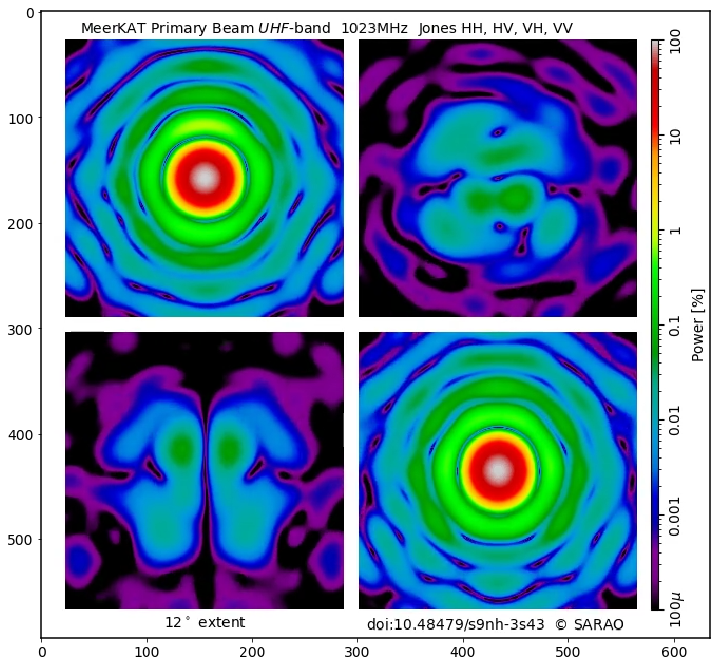

In [24]:
import matplotlib.image as mpimg
img = mpimg.imread('beam_ref.png')
plt.figure(figsize = (12,12))
imgplot = plt.imshow(img)
plt.show()

# $\textcolor{Red}{\text {\bf !!! pattern is [el,az], same to L-band}}$

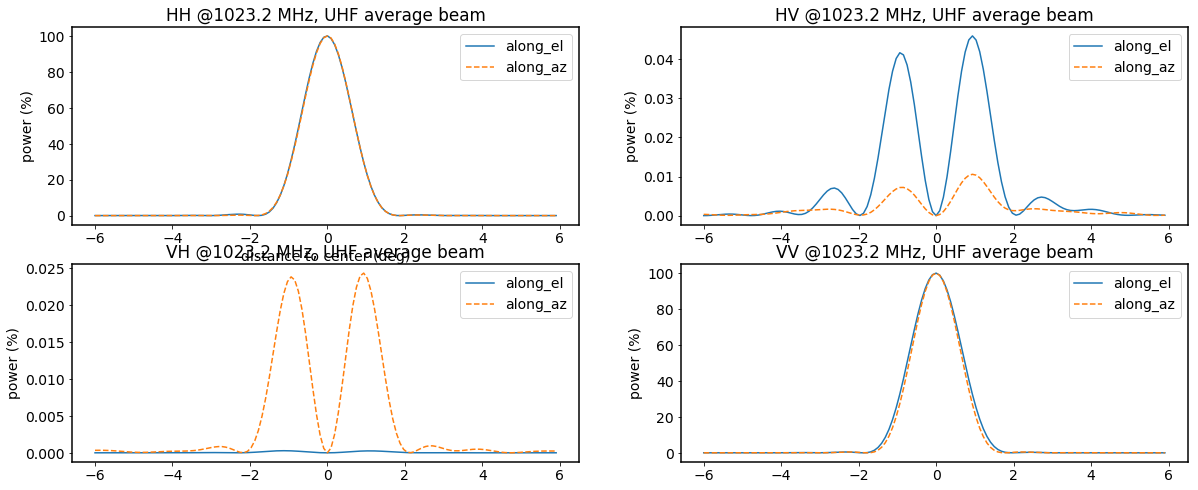

In [25]:
plt.figure(figsize=(20,8))
plt.subplot(221)
plt.plot(margin_deg, img_HH[:,64]*100)
plt.plot(margin_deg, img_HH[64,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.xlabel('distance to center (deg)')
plt.ylabel('power (%)')
plt.title('HH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(222)
plt.plot(margin_deg, img_HV[:,64]*100)
plt.plot(margin_deg, img_HV[64,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('HV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(223)
plt.plot(margin_deg, img_VH[:,64]*100)
plt.plot(margin_deg, img_VH[64,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(224)
plt.plot(margin_deg, img_VV[:,64]*100)
plt.plot(margin_deg, img_VV[64,:]*100,'--')
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.show()

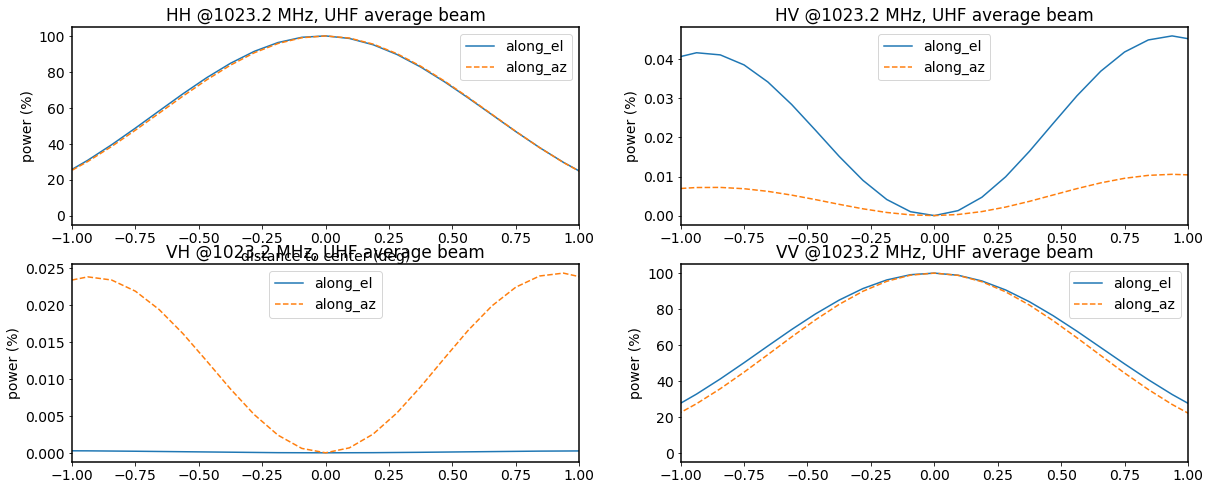

In [26]:
plt.figure(figsize=(20,8))
plt.subplot(221)
plt.plot(margin_deg, img_HH[:,64]*100)
plt.plot(margin_deg, img_HH[64,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.xlabel('distance to center (deg)')
plt.ylabel('power (%)')
plt.title('HH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(222)
plt.plot(margin_deg, img_HV[:,64]*100)
plt.plot(margin_deg, img_HV[64,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('HV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(223)
plt.plot(margin_deg, img_VH[:,64]*100)
plt.plot(margin_deg, img_VH[64,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VH @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.subplot(224)
plt.plot(margin_deg, img_VV[:,64]*100)
plt.plot(margin_deg, img_VV[64,:]*100,'--')
plt.xlim(-1,1)
plt.legend(['along_el','along_az'])
plt.ylabel('power (%)')
plt.title('VV @'+str(round(freq_local,1))+' MHz, UHF average beam')
plt.show()

In [27]:
#end

In [28]:
Ddeg=12. #UHF

In [29]:
D_MeerKAT=13.5 #14.0 Khan preferred 14.0

In [30]:
freq0=freqs_MHz[grid_i]*1e6 #freq*1e6
sigma0=0.45*(3e8/freq0)/D_MeerKAT/np.pi*180.
print (sigma0)

sigma0_pix=sigma0/Ddeg*Npix

print (sigma0_pix)

0.55997341164823
5.973049724247787


In [31]:
r_cut=6.
pix_cut=r_cut/Ddeg*Npix
print (r_cut,pix_cut)

6.0 64.0


In [32]:
img=img_VV
center_x0=np.where(img[:,:]==img[:,:].max())[1][0]
center_y0=np.where(img[:,:]==img[:,:].max())[0][0]
print (center_x0,center_y0)
#print (np.std(img_VV))

64 64


In [33]:
#img=img_VV

In [34]:
xlist=[]
ylist=[]
zlist=[]
imgsize=img.shape[0]
img_cut=np.zeros([imgsize,imgsize])

for i in range(0, imgsize):
    for j in range(0, imgsize):
        r=np.sqrt((j-center_x0)**2+(i-center_y0)**2)
        x=float(j)
        y=float(i)
        if r<=pix_cut:
            img_cut[i,j]=img[i,j]
            
            xlist.append(x)
            ylist.append(y)
            zlist.append(img[i,j])
           

In [35]:
print (np.nanmean(zlist), np.nanstd(zlist)) 

0.019581646 0.09943919


In [36]:
z=np.array(zlist)
assert(z.max()==1)
Omega_A=(Ddeg/Npix/180.*np.pi)**2*z.sum()
light_speed = 2.99792485e8
#lbd = light_speed / (freqs[grid_i]*1e6)
lbd = light_speed / (freqs_MHz[grid_i]*1e6)
Aeff_max=lbd**2/Omega_A
print (Aeff_max)

127.42293877115019


In [37]:
Aeff_max

127.42293877115019

In [38]:
fit_result=opt.fmin_powell(func=func_obj, x0=[sigma0_pix,center_x0,center_y0], args=(np.array(xlist), np.array(ylist), np.array(zlist)),xtol=1e-10,ftol=1e-10)
sigma=fit_result[0]
sigma_deg=sigma/Npix*Ddeg
print (sigma_deg, sigma)
center_x1=fit_result[1]
center_y1=fit_result[2]

sig_factor=sigma0/sigma_deg
print (fit_result)
print (sig_factor,sig_factor**2)

Optimization terminated successfully.
         Current function value: 0.452970
         Iterations: 3
         Function evaluations: 193
0.5959954984643794 6.35728531695338
[ 6.35728532 63.97602194 63.98596397]
0.9395598005203687 0.882772618753875


In [39]:
model_value=np.zeros([imgsize,imgsize])
for i in range(0, imgsize):
    for j in range(0, imgsize):
        r=np.sqrt((j-center_x0)**2+(i-center_y0)**2)
        x=float(j)
        y=float(i)
        if r<=pix_cut:
            model_value[i,j]=gauss_model(x, y, center_x=center_x1,center_y=center_y1,sigma=sigma)

In [40]:
error=model_value-img_cut
print (error.mean(),error.min(),error.max())

0.00013987258597470968 -0.04767672837903836 0.03313068960386176


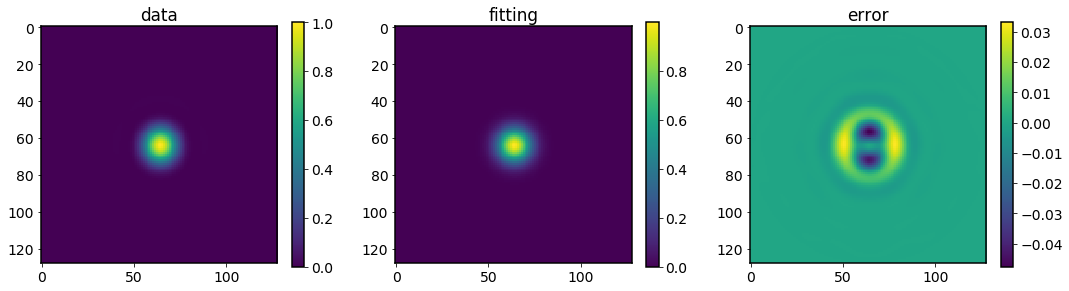

In [41]:

plt.figure(figsize = (18,4.5))
plt.subplot(131)
plt.imshow(img_cut)
plt.title('data')
plt.colorbar()
plt.subplot(132)
plt.imshow(model_value)
plt.title('fitting')
plt.colorbar()
plt.subplot(133)
plt.imshow(error)
plt.title('error')
plt.colorbar()
plt.show()

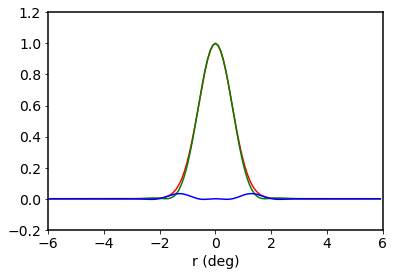

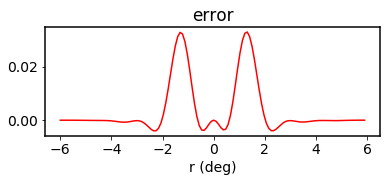

In [42]:
plt.figure(figsize=(6,4))
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,model_value[center_y0,:],'r')
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,img_cut[center_y0,:],'g')
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,model_value[center_y0,:]-img_cut[center_y0,:],'b')
plt.ylim(-0.2,1.2)
plt.xlim(-r_cut,r_cut)
plt.xlabel('r (deg)')
plt.show()
plt.figure(figsize=(6,2))
plt.plot((range(Npix)-center_y0)/float(Npix)*Ddeg,error[center_y0,:],'r-')
plt.title('error')
plt.xlabel('r (deg)')
plt.show()

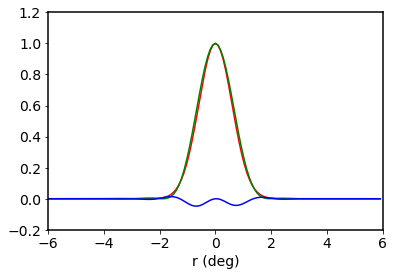

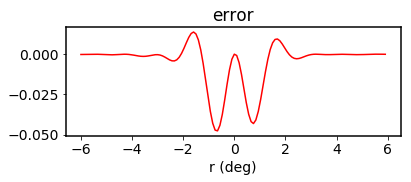

In [43]:
plt.figure(figsize=(6,4))
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,model_value[:,center_x0],'r')
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,img_cut[:,center_x0],'g')
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,model_value[:,center_x0]-img_cut[:,center_x0],'b')
plt.ylim(-0.2,1.2)
plt.xlim(-r_cut,r_cut)
plt.xlabel('r (deg)')
plt.show()
plt.figure(figsize=(6,2))
plt.plot((range(Npix)-center_x0)/float(Npix)*Ddeg,error[:,center_x0],'r-')
plt.title('error')
plt.xlabel('r (deg)')
plt.show()

In [44]:
#end

In [45]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Thu Dec 26 15:55:51 2024#


# check the full band result

In [46]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')

start @ Thu Dec 26 15:55:51 2024#


In [47]:
file11='beam_fit_data'
print (file11)
data1=pickle.load(open(file11,'rb'))


beam_fit_data


In [48]:
data1.keys()

dict_keys(['grid_freq', 'sigma_HH', 'sigma_VV', 'Aeff_max_HH', 'Aeff_max_VV'])

In [49]:
grid_freq1=data1['grid_freq']
sigma1_HH=data1['sigma_HH']
sigma1_VV=data1['sigma_VV']
Aeff_max_HH=data1['Aeff_max_HH']
Aeff_max_VV=data1['Aeff_max_VV']
grid_freq1=np.array(grid_freq1)
sigma1_HH=np.array(sigma1_HH)
sigma1_VV=np.array(sigma1_VV)
Aeff_max_HH=np.array(Aeff_max_HH)
Aeff_max_VV=np.array(Aeff_max_VV)

In [50]:
print (grid_i, sigma1_HH[grid_i], sigma1_VV[grid_i])

902 0.5978962211925487 0.5959954984643794


In [51]:
print (len(grid_freq1),len(sigma1_HH),len(sigma1_VV))


1024 1024 1024


In [52]:
assert((grid_freq1==freqs_MHz).all())

In [53]:
D_MeerKAT1=13.5


In [54]:
freq1=grid_freq1*1e6
sigma0_1=np.degrees(0.45*(3e8/freq1)/D_MeerKAT1)


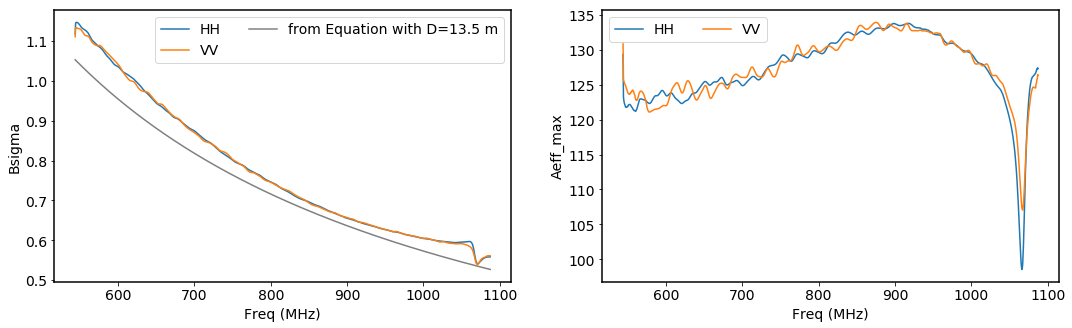

In [55]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(grid_freq1,sigma1_HH,'C0')
plt.plot(grid_freq1,sigma1_VV,'C1')
plt.plot(grid_freq1,sigma0_1,'grey')
plt.legend(['HH','VV', 'from Equation with D=13.5 m'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(122)
plt.plot(grid_freq1,Aeff_max_HH,'C0')
plt.plot(grid_freq1,Aeff_max_VV,'C1')
plt.legend(['HH','VV'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.show()
plt.show()

In [56]:
for i in range(1024):
    j=4*i
    print (grid_freq1[i]-kio.cal_freq_UHF(j)/1e6,end=' ')

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

In [57]:
freqs_flist=np.array(kio.cal_freqs_UHF(range(4096)))/1e6
print (freqs_flist)

[ 544.         544.1328125  544.265625  ... 1087.6015625 1087.734375
 1087.8671875]


In [58]:
def rbf_spline(x_list1,y_list1,x_list2):
    rbf_func=Rbf(x_list1,y_list1)
    y_list2=rbf_func(x_list2)
    return y_list2

In [59]:
sigma_HH_full=rbf_spline(grid_freq1,sigma1_HH,freqs_flist)
sigma_VV_full=rbf_spline(grid_freq1,sigma1_VV,freqs_flist)
Aeff_max_HH_full=rbf_spline(grid_freq1,Aeff_max_HH,freqs_flist)
Aeff_max_VV_full=rbf_spline(grid_freq1,Aeff_max_VV,freqs_flist)

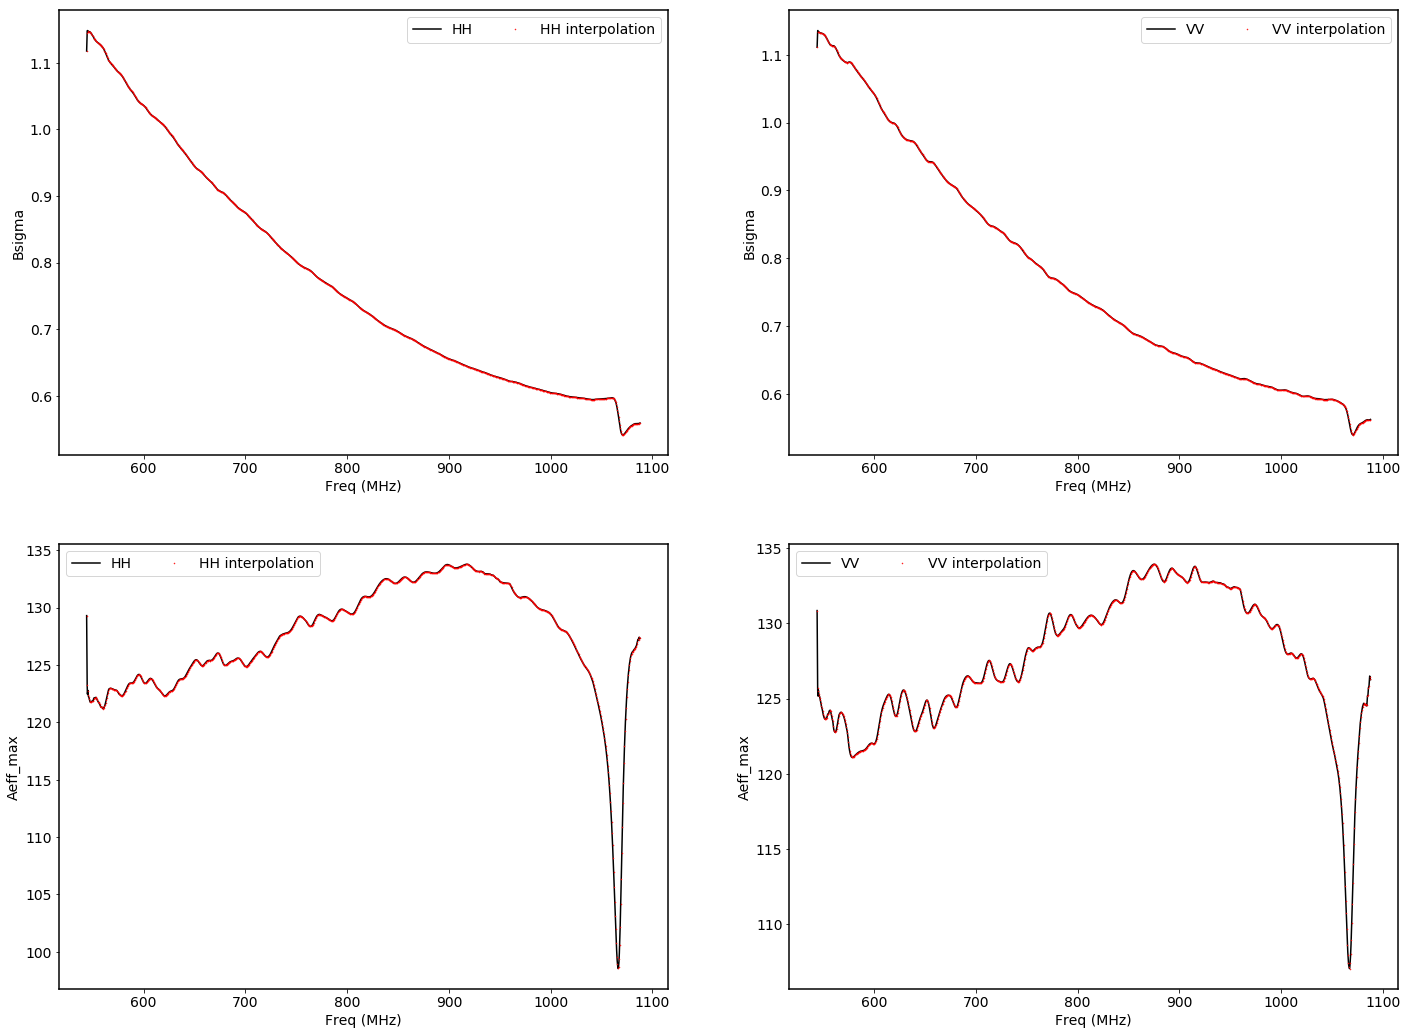

In [60]:
plt.figure(figsize=(24,18))
plt.subplot(221)
plt.plot(freqs_flist,sigma_HH_full,'k')
plt.plot(grid_freq1,sigma1_HH,'r.',ms=1)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(222)
plt.plot(freqs_flist,sigma_VV_full,'k')
plt.plot(grid_freq1,sigma1_VV,'r.',ms=1)
plt.legend(['VV', 'VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(223)
plt.plot(freqs_flist,Aeff_max_HH_full,'k')
plt.plot(grid_freq1,Aeff_max_HH,'r.',ms=1)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.subplot(224)
plt.plot(freqs_flist,Aeff_max_VV_full,'k')
plt.plot(grid_freq1,Aeff_max_VV,'r.',ms=1)
plt.legend(['VV','VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.show()

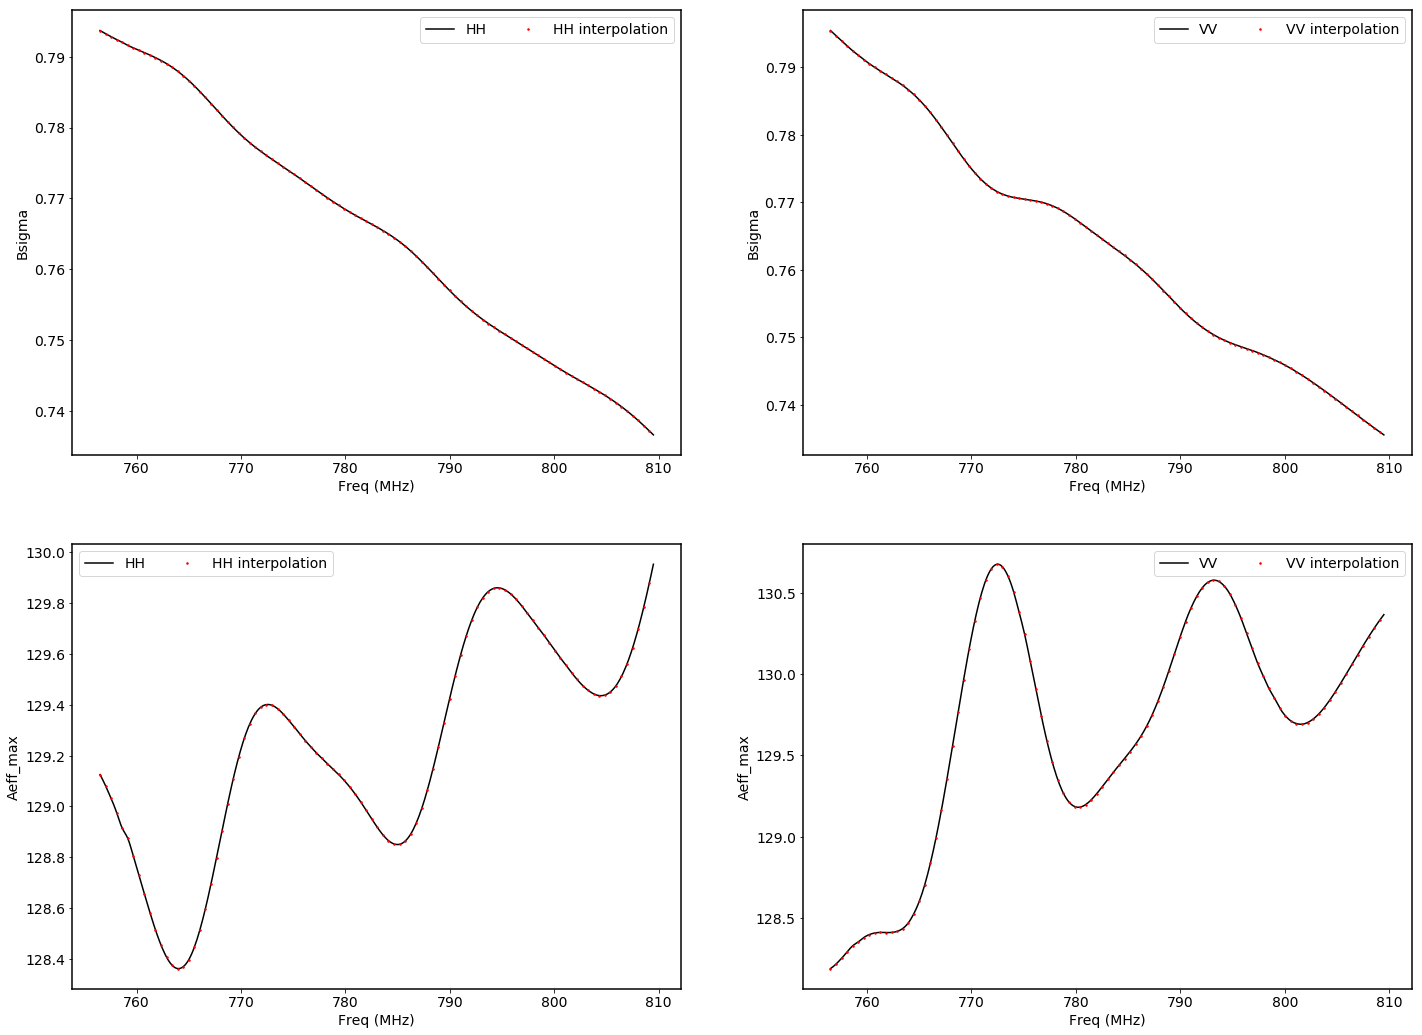

In [61]:
ch1,ch2=400,500
ch11,ch22=ch1*4,ch2*4
plt.figure(figsize=(24,18))
plt.subplot(221)
plt.plot(freqs_flist[ch11:ch22],sigma_HH_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],sigma1_HH[ch1:ch2],'r.',ms=3)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(222)
plt.plot(freqs_flist[ch11:ch22],sigma_VV_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],sigma1_VV[ch1:ch2],'r.',ms=3)
plt.legend(['VV', 'VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Bsigma')
plt.subplot(223)
plt.plot(freqs_flist[ch11:ch22],Aeff_max_HH_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],Aeff_max_HH[ch1:ch2],'r.',ms=3)
plt.legend(['HH','HH interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.subplot(224)
plt.plot(freqs_flist[ch11:ch22],Aeff_max_VV_full[ch11:ch22],'k')
plt.plot(grid_freq1[ch1:ch2],Aeff_max_VV[ch1:ch2],'r.',ms=3)
plt.legend(['VV','VV interpolation'], ncol=2)
plt.xlabel('Freq (MHz)')
plt.ylabel('Aeff_max')
plt.show()

In [62]:
print (len(freqs_flist),len(sigma_HH_full),len(sigma_VV_full),len(Aeff_max_HH_full),len(Aeff_max_VV_full))

4096 4096 4096 4096 4096


In [63]:
data_p={}
data_p['freqs']=freqs_flist
data_p['sigma_HH']=sigma_HH_full
data_p['sigma_VV']=sigma_VV_full
data_p['Aeff_max_HH']=Aeff_max_HH_full
data_p['Aeff_max_VV']=Aeff_max_VV_full
fs=open('beam_spline_data','wb')
pickle.dump(data_p,fs,protocol=2)
fs.close()


In [64]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Thu Dec 26 15:55:57 2024#
